In [19]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [20]:
def load_dataset(csv_path):
    df = pd.read_csv(csv_path, sep= ';')
    required_columns = ['Azimuth', 'Altitude', 'Timestamp']

    if not all (col in df.columns for col in required_columns):
        raise ValueError("Required columns are not present in the DataFrame.")
    
    X = df['Timestamp'].values.reshape(-1, 1)
    y = df['Azimuth'].values

    return X, y, df

In [21]:
csv_path = 'cleaned/cleaned_data_quartal_1_2020.csv'
X, y, df = load_dataset(csv_path)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state= 42)

In [23]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [24]:
timesteps = 1

In [25]:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], timesteps, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1]))

In [26]:
model = Sequential()
model.add(LSTM(units=100, activation='relu', input_shape=(timesteps, X_train_scaled.shape[1]), return_sequences=True))
model.add(LSTM(units=50, activation= 'relu'))
model.add(Dense(units=1))

optimizer = Adam(learning_rate= 0.0001)
model.compile(optimizer=optimizer, loss = 'mse')

model.fit(X_train_reshaped, y_train_scaled, epochs= 50, batch_size = 32)

Epoch 1/50
328/328 [==============================] - 6s 12ms/step - loss: 0.2508
Epoch 2/50
328/328 [==============================] - 4s 12ms/step - loss: 0.1214
Epoch 3/50
328/328 [==============================] - 4s 13ms/step - loss: 0.0578
Epoch 4/50
328/328 [==============================] - 5s 14ms/step - loss: 0.0533
Epoch 5/50
328/328 [==============================] - 5s 15ms/step - loss: 0.0501
Epoch 6/50
328/328 [==============================] - 5s 14ms/step - loss: 0.0477
Epoch 7/50
328/328 [==============================] - 4s 14ms/step - loss: 0.0459
Epoch 8/50
328/328 [==============================] - 7s 21ms/step - loss: 0.0446
Epoch 9/50
328/328 [==============================] - 5s 16ms/step - loss: 0.0438
Epoch 10/50
328/328 [==============================] - 5s 15ms/step - loss: 0.0433
Epoch 11/50
328/328 [==============================] - 5s 15ms/step - loss: 0.0430
Epoch 12/50
328/328 [==============================] - 5s 14ms/step - loss: 0.0428
Epoch 13/50
3

In [ ]:
predicted_values_scaled = model.predict(X_test_reshaped)
predicted_values = scaler_y.inverse_transform(predicted_values_scaled)
mse = mean_squared_error(y_test_scaled, predicted_values_scaled)
print(f"Mean Squared Error on Test Data: {mse}")

82/82 [==============================] - 0s 3ms/step


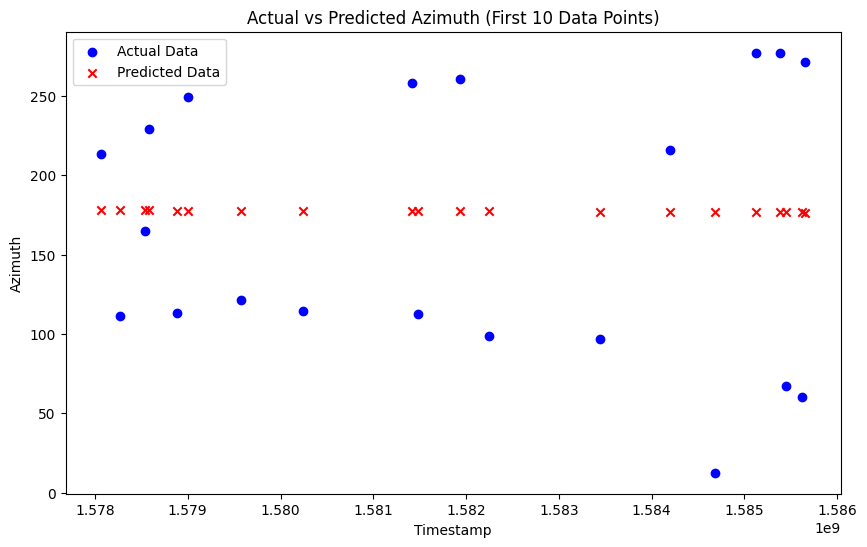

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:20], y_test[:20], label='Actual Data', color='blue')
plt.scatter(X_test[:20], predicted_values[:20], label='Predicted Data', color='red', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Azimuth')
plt.title('Actual vs Predicted Azimuth (First 10 Data Points)')
plt.legend()
plt.show()